In [1]:
import numpy as np
import pandas as pd
import itertools
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import math
import statsmodels.api as sm
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize']=23
matplotlib.rcParams['xtick.labelsize']=14
matplotlib.rcParams['ytick.labelsize']=14
matplotlib.rcParams['text.color']='k'

**Fetching the data**

In [2]:
import re

def extract_date_from_excel_filename(filename):
    # Define a regular expression pattern to match the date in the filename
    date_pattern = r'\d{4}-\d{2}-\d{2}'
    
    # Use the re.search function to find the date in the filename
    match = re.search(date_pattern, filename)
    
    if match:
        # Extract the matched date and return it
        date_str = match.group()
        return date_str
    else:
        # If no date is found, return None or raise an exception, depending on your needs
        return None

# Example usage:
filename = "Item List KHOFFMAN 2023-10-02T15_43_14.xlsx"
date = extract_date_from_excel_filename(filename)
if date:
    print("Extracted date:", date)
else:
    print("No date found in the filename.")

Extracted date: 2023-10-02


In [3]:
stock_sheet=pd.read_excel('./data/Stock_Sheet.xlsx')
stock_sheet.head(4)

,Item No.,SKU,Set of 2,Status,Closeout Date,Discontinue Date,Quantity OH - VL,Qty. on Purch. Order,Qty. on Sales Order,On Hand Available,...,P3 ETA,P3 PQ,P3 Code,Piece 4,Piece 4 Qty,P4 Stock,P4 Resupply,P4 ETA,P4 PQ,P4 Code
0,LCMOSOGRAY,LCMOSOGRAY,NaN,0,NaT,2019-04-30,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LCWECHGR,LCWECHGR,Set of 2,0,NaT,2020-06-12,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LCMNCHGR,LCMNCHGR,Set of 2,0,NaT,2018-07-25,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LCZACHBR,LCZACHBR,Set of 2,0,NaT,2019-01-02,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# AMP100 - OH All foalder
path = "./data/inventory/AMP100 - OH All/"
files = os.listdir(path)
files_xlsx = [f for f in files if f.endswith('.xlsx')]
mydf_list = []
for file in files_xlsx:
    date_ = extract_date_from_excel_filename(file)
    mydf = pd.read_excel(os.path.join(path, file))
    mydf['Date'] = date_
    mydf_list.append(mydf)


df_AMP100 = pd.concat(mydf_list)

In [5]:
df_AMP100.head(5)

,No.,Description,Description 2,Quantity OH - VL,Quantity OH - LA10,Quantity on Hand,Qty. on Sales Order,Qty. on Purch. Order,Qty. on Purch. Qoute,Base Unit of Measure,...,Vendor No.,Qty. on Asm. Component,Available to Make\n-VL,Date,Sales Unit of Measure,Shelf No.,Inventory Posting Group,Item Category Code,Product Group Code,Lead Time Calculation
0,==LC9793SB,979lc SOFA LEATHER SADDLE,BROWN TX106,0,0,0,0,0,0,PCS,...,STYLUTION,0,0,2023-10-18,NaN,NaN,NaN,NaN,NaN,NaN
1,==LC9951CO,995 CHAIR LEATHER COGNAC,DM717,0,0,0,0,0,0,PCS,...,STYLUTION,0,0,2023-10-18,NaN,NaN,NaN,NaN,NaN,NaN
2,==LC9951SB,995 CHAIR LEATHER SADDLE,BROWN TX106,0,0,0,0,0,0,PCS,...,STYLUTION,0,0,2023-10-18,NaN,NaN,NaN,NaN,NaN,NaN
3,==LC9951WI,995 CHAIR WINE LEATHER TX104,NaN,0,0,0,0,0,0,PCS,...,STYLUTION,0,0,2023-10-18,NaN,NaN,NaN,NaN,NaN,NaN
4,==LC9952CO,995 LOVESEAT LEATHER COGNAC,DM717,0,0,0,0,0,0,PCS,...,STYLUTION,0,0,2023-10-18,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_AMP100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175384 entries, 0 to 14646
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   No.                      175384 non-null  object 
 1   Description              151695 non-null  object 
 2   Description 2            105819 non-null  object 
 3   Quantity OH - VL         175384 non-null  int64  
 4   Quantity OH - LA10       175384 non-null  int64  
 5   Quantity on Hand         175384 non-null  int64  
 6   Qty. on Sales Order      175384 non-null  int64  
 7   Qty. on Purch. Order     175384 non-null  int64  
 8   Qty. on Purch. Qoute     175384 non-null  int64  
 9   Base Unit of Measure     174591 non-null  object 
 10  Unit Price               175384 non-null  float64
 11  Vendor No.               174074 non-null  object 
 12  Qty. on Asm. Component   175384 non-null  int64  
 13  Available to Make
-VL    175384 non-null  int64  
 14  Date 

In [7]:
print(df_AMP100.duplicated())

0        False
1        False
2        False
3        False
4        False
         ...  
14642    False
14643    False
14644    False
14645    False
14646    False
Length: 175384, dtype: bool


In [8]:
df_stock =df_AMP100.drop_duplicates()

In [9]:
# Nav Items - OH VL All foalder
path = "./data/inventory/Nav Items - OH VL/"
files = os.listdir(path)
files_xlsx = [f for f in files if f.endswith('.xlsx')]
mydf_list = []
for file in files_xlsx:
    date_ = extract_date_from_excel_filename(file)
    mydf = pd.read_excel(os.path.join(path, file))
    mydf['Date'] = date_
    mydf_list.append(mydf)
    
df_items = pd.concat(mydf_list)

In [10]:
df_items.head(4)

,Cross-Reference No.,Item No.,Unique UPC,Cross-Reference No. 2,Variant Code,Unit of Measure,Item Description,Discontinue Bar Code,Description,Quantity on Hand,...,Qty on KY,Qty on UT,Qty on NH,Inventory on NJ,Inventory on UK,Inventory on CA2,Wayfair 846 Qty,Expected Receipt Date,846 Item No.,Date
0,LC0845BEBL,LC0845BEBL,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS BLAC,0,NaN,99,...,0,0,0,0,0,0,97,NaT,NaN,2023-10-18
1,LC0845BEBR,LC0845BEBR,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS BROW,0,NaN,0,...,0,0,0,0,0,0,0,NaT,NaN,2023-10-18
2,LC0845BEGR,LC0845BEGR,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS GRAY,0,NaN,0,...,0,0,0,0,0,0,0,NaT,NaN,2023-10-18
3,LC0845BEPU,LC0845BEPU,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS PURP,0,NaN,0,...,0,0,0,0,0,0,0,NaT,NaN,2023-10-18


In [11]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62962 entries, 0 to 4436
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cross-Reference No.    62962 non-null  object 
 1   Item No.               62962 non-null  object 
 2   Unique UPC             888 non-null    object 
 3   Cross-Reference No. 2  57148 non-null  object 
 4   Variant Code           0 non-null      float64
 5   Unit of Measure        62525 non-null  object 
 6   Item Description       62962 non-null  object 
 7   Discontinue Bar Code   62962 non-null  int64  
 8   Description            0 non-null      float64
 9   Quantity on Hand       62962 non-null  int64  
 10  Qty. on Purch. Order   62962 non-null  int64  
 11  Qty. on Sales Order    62962 non-null  int64  
 12  On Hand Available      62962 non-null  int64  
 13  Qty on KY              62962 non-null  int64  
 14  Qty on UT              62962 non-null  int64  
 15  Qty

In [12]:
print(df_items.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
4432    False
4433    False
4434    False
4435    False
4436    False
Length: 62962, dtype: bool


In [13]:
df_item =df_items.drop_duplicates()

In [14]:
# Config Pack - PQ PO foalder
path = "./data/inventory/Config Pack - PQ PO/"
files = os.listdir(path)
files_xlsx = [f for f in files if f.endswith('.xlsx')]
mydf_list = []
for file in files_xlsx:
    date_ = extract_date_from_excel_filename(file)
    mydf = pd.read_excel(os.path.join(path, file))
    mydf['Date'] = date_
    mydf_list.append(mydf)
    
df_config = pd.concat(mydf_list)

In [15]:
df_config.head(4)

,Document Type,Document No.,Line No.,Buy-from Vendor No.,Type,No.,Location Code,Expected Receipt Date,Description,Description 2,...,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,Quote,4716.0,30000.0,HC,Item,LCGRBAWACR30,VL,2023-11-30,9013 GRADY 30 BARSTL CREAM,PU/WALNUT WOOD FRAME,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Quote,4716.0,40000.0,HC,Item,LCGRBAWAGR26,VL,2023-11-30,9013 GRADY 26 BARSTL GREY,PU/WALNUT WOOD FRAME,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Quote,4716.0,50000.0,HC,Item,LCRNBAWACR26,VL,2023-11-30,9033-13 RENEE 26 BARSTL CREAM,PU/WALNUT WOOD FRAME,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Quote,4716.0,60000.0,HC,Item,LCRNBAWAGR30,VL,2023-11-30,9033-13 RENEE 30 BARSTL GREY,PU/WALNUT WOOD FRAME,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_config.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86129 entries, 0 to 1024
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Document Type            13300 non-null  object        
 1   Document No.             84789 non-null  float64       
 2   Line No.                 84789 non-null  float64       
 3   Buy-from Vendor No.      13300 non-null  object        
 4   Type                     13300 non-null  object        
 5   No.                      83935 non-null  object        
 6   Location Code            83935 non-null  object        
 7   Expected Receipt Date    13300 non-null  datetime64[ns]
 8   Description              84731 non-null  object        
 9   Description 2            12947 non-null  object        
 10  Outstanding Quantity     13300 non-null  float64       
 11  Column1                  13300 non-null  float64       
 12  Direct Unit Cost         13300 no

In [17]:
def clean_number(df, my_column):
    df[my_column] = df[my_column].str.replace('==', '')


df_item = df_item.rename({
          'Item No.':'No.'
        }, axis='columns')

clean_number(df_stock,'No.')
clean_number(df_item,'No.')
clean_number(df_config,'No.')   

In [18]:
item = pd.merge(df_stock,df_item, on="No.") 

In [19]:
item.head(3)

,No.,Description_x,Description 2,Quantity OH - VL,Quantity OH - LA10,Quantity on Hand_x,Qty. on Sales Order_x,Qty. on Purch. Order_x,Qty. on Purch. Qoute,Base Unit of Measure,...,Qty on KY,Qty on UT,Qty on NH,Inventory on NJ,Inventory on UK,Inventory on CA2,Wayfair 846 Qty,Expected Receipt Date,846 Item No.,Date_y
0,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16
1,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16
2,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16


In [20]:
print(item.duplicated())

0         False
1         False
2         False
3         False
4         False
          ...  
754691    False
754692    False
754693    False
754694    False
754695    False
Length: 754696, dtype: bool


In [21]:
print(item[item.duplicated()])

Empty DataFrame
Columns: [No., Description_x, Description 2, Quantity OH - VL, Quantity OH - LA10, Quantity on Hand_x, Qty. on Sales Order_x, Qty. on Purch. Order_x, Qty. on Purch. Qoute, Base Unit of Measure, Unit Price, Vendor No., Qty. on Asm. Component, Available to Make
-VL, Date_x, Sales Unit of Measure, Shelf No., Inventory Posting Group, Item Category Code, Product Group Code, Lead Time Calculation, Cross-Reference No., Unique UPC, Cross-Reference No. 2, Variant Code, Unit of Measure, Item Description, Discontinue Bar Code, Description_y, Quantity on Hand_y, Qty. on Purch. Order_y, Qty. on Sales Order_y, On Hand Available, Qty on KY, Qty on UT, Qty on NH, Inventory on NJ, Inventory on UK, Inventory on CA2, Wayfair 846 Qty, Expected Receipt Date, 846 Item No., Date_y]
Index: []

[0 rows x 43 columns]


In [22]:
print(item.duplicated().sum())

0


In [23]:
df =item.drop_duplicates()

In [24]:
print(df.duplicated().sum())

0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754696 entries, 0 to 754695
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   No.                      754696 non-null  object 
 1   Description_x            754696 non-null  object 
 2   Description 2            726124 non-null  object 
 3   Quantity OH - VL         754696 non-null  int64  
 4   Quantity OH - LA10       754696 non-null  int64  
 5   Quantity on Hand_x       754696 non-null  int64  
 6   Qty. on Sales Order_x    754696 non-null  int64  
 7   Qty. on Purch. Order_x   754696 non-null  int64  
 8   Qty. on Purch. Qoute     754696 non-null  int64  
 9   Base Unit of Measure     754696 non-null  object 
 10  Unit Price               754696 non-null  float64
 11  Vendor No.               754396 non-null  object 
 12  Qty. on Asm. Component   754696 non-null  int64  
 13  Available to Make
-VL    754696 non-null  int64  
 14  Date

In [26]:
df.head(3)

,No.,Description_x,Description 2,Quantity OH - VL,Quantity OH - LA10,Quantity on Hand_x,Qty. on Sales Order_x,Qty. on Purch. Order_x,Qty. on Purch. Qoute,Base Unit of Measure,...,Qty on KY,Qty on UT,Qty on NH,Inventory on NJ,Inventory on UK,Inventory on CA2,Wayfair 846 Qty,Expected Receipt Date,846 Item No.,Date_y
0,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16
1,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16
2,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16


**Data analysis**

1. trend per item

In [27]:
df.head(2)

,No.,Description_x,Description 2,Quantity OH - VL,Quantity OH - LA10,Quantity on Hand_x,Qty. on Sales Order_x,Qty. on Purch. Order_x,Qty. on Purch. Qoute,Base Unit of Measure,...,Qty on KY,Qty on UT,Qty on NH,Inventory on NJ,Inventory on UK,Inventory on CA2,Wayfair 846 Qty,Expected Receipt Date,846 Item No.,Date_y
0,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16
1,ATAB08080001,A WAY OUT I - SQUARE BLACK AND GREY WRAPPED CA...,WALL ART PRINT 8X8,0,0,100,0,0,0,PCS,...,0,0,0,0,0,0,0,NaT,ATAB08080001,2023-10-16


In [28]:
item_trend = df[['Date_x','No.','Quantity on Hand_x', 'Qty. on Sales Order_x','Qty. on Purch. Order_x','Quantity OH - VL']]
item_trend.head()

,Date_x,No.,Quantity on Hand_x,Qty. on Sales Order_x,Qty. on Purch. Order_x,Quantity OH - VL
0,2023-10-18,ATAB08080001,100,0,0,0
1,2023-10-06,ATAB08080001,100,0,0,0
2,2023-10-04,ATAB08080001,100,0,0,0
3,2023-11-01,ATAB08080001,100,0,0,0
4,2023-10-30,ATAB08080001,100,0,0,0


In [29]:
# convert object to date and check the min and max date
item_trend['Date_x'] = pd.to_datetime(item_trend['Date_x'])
print('Min date from dataset: %s' % item_trend['Date_x'].min().date())
print('Max date from dataset: %s' % item_trend['Date_x'].max().date())

Min date from dataset: 2023-10-02
Max date from dataset: 2023-11-06


In [30]:
import pandas as pd

def filter_rows_by_value(dataframe, column_name, value):
    """
    Filter rows in a DataFrame based on a particular value in a specified column.

    Parameters:
    - dataframe: pandas DataFrame
        The input DataFrame containing the data.
    - column_name: str
        The name of the column to filter on.
    - value: any
        The value to filter rows on.

    Returns:
    - pandas DataFrame
        A new DataFrame containing only the rows that match the specified value in the specified column.
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in dataframe.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return None

    # Filter rows based on the specified value in the specified column
    filtered_dataframe = dataframe[dataframe[column_name] == value]

    return filtered_dataframe

In [31]:
def plot_trend_item(item_df, column,item_number):
    filtered_data = filter_rows_by_value(item_df, column, item_number)
    plt.plot(sorted(filtered_data['Date_x']), sorted(filtered_data['Quantity OH - VL']),color='r', label='Quantity OH - VL')
    plt.plot(sorted(filtered_data['Date_x']), sorted(filtered_data['Qty. on Sales Order_x']),color='b', label='Qty. on Sales Order')
    plt.plot(sorted(filtered_data['Date_x']), sorted(filtered_data['Qty. on Purch. Order_x']),color='g', label='Qty. on Purch. Order')
    plt.gcf().autofmt_xdate()
    plt.xlabel("Date") 
    plt.ylabel("Quantity") 
    plt.title(f"Quanity on hand, sales and Pursache for item No = {filtered_data.iloc[0]['No.']}")
    plt.legend() 

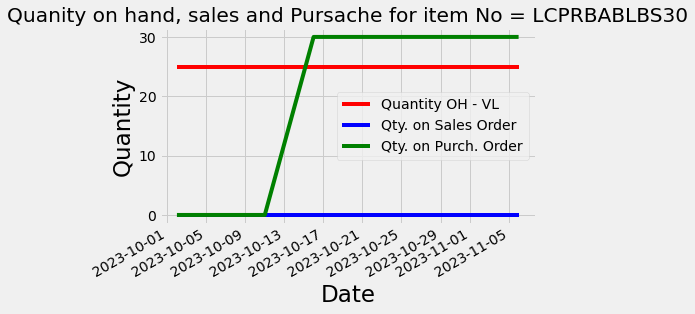

In [32]:
plot_trend_item(item_trend,'No.','LCPRBABLBS30')

**Modeling**

1. Predict when an item will go out of stock

In [69]:
## function forecast sale by item
def forcaste_sale_by_item(item_df, column,item_number):
    sale_forcast = filter_rows_by_value(item_df, column, item_number)
    sale_forcast = item_trend[['Date_x','Qty. on Sales Order_x']]

    sale_forcast = sale_forcast.groupby("Date_x")['Qty. on Sales Order_x'].sum().reset_index()
    sale_forcast.set_index("Date_x", inplace = True)

    y = sale_forcast["Qty. on Sales Order_x"].resample('MS').mean() #MS mean Month Star

    mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    pred_uc = results.get_forecast(steps=13)
    pred_ci = pred_uc.conf_int()
    ax = y.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    print(pred_ci)
    plt.legend()
    plt.show()  
    return pred_ci  

##function forcast available by item
def forcaste_available_by_item(item_df, column,item_number):
    sale_forcast = filter_rows_by_value(item_df, column, item_number)
    sale_forcast = item_trend[['Date_x','Quantity OH - VL']]

    sale_forcast = sale_forcast.groupby("Date_x")['Quantity OH - VL'].sum().reset_index()
    sale_forcast.set_index("Date_x", inplace = True)

    y = sale_forcast["Quantity OH - VL"].resample('MS').mean() #MS mean Month Star

    mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    pred_uc = results.get_forecast(steps=13)
    pred_ci = pred_uc.conf_int()
    ax = y.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Available')
    print(pred_ci)
    plt.legend()
    plt.show()    
    return pred_ci  

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
            lower Qty. on Sales Order_x  upper Qty. on Sales Order_x
2023-12-01                165197.691658                170741.308342
2024-01-01                164049.571051                1

 This problem is unconstrained.


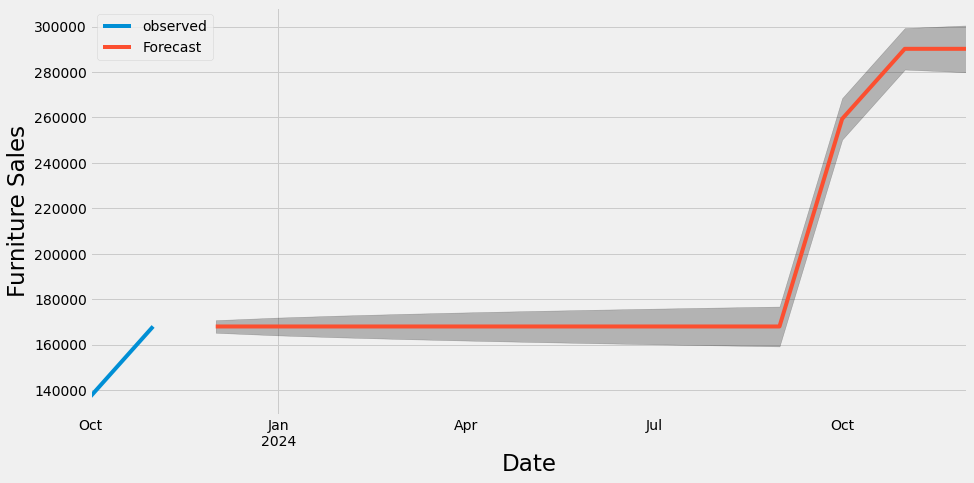

In [70]:
mean_sales = forcaste_sale_by_item(item_trend, 'No.', 'LCPRBABLBS30')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
            lower Quantity OH - VL  upper Quantity OH - VL
2023-12-01            1.096261e+06            1.101805e+06
2024-01-01            1.095113e+06            1.102953e+06
2024-02-01       

 This problem is unconstrained.


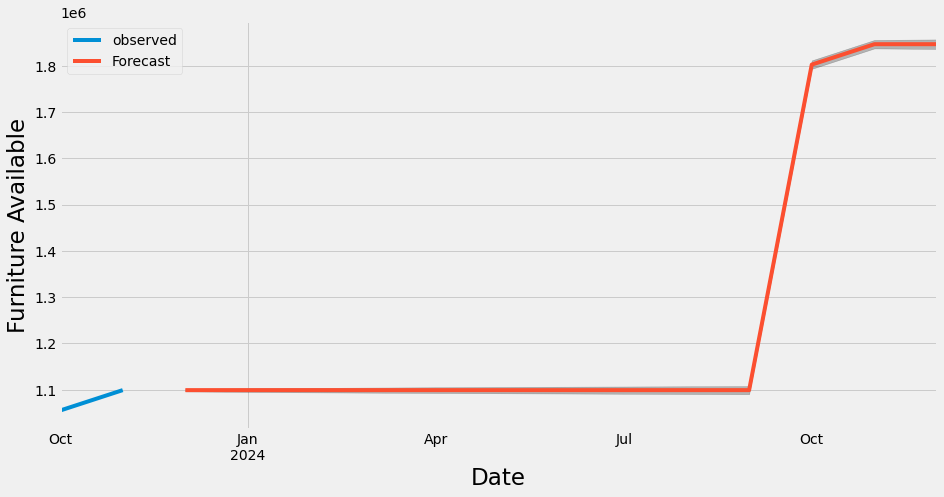

In [71]:
mean_available = forcaste_available_by_item(item_trend, 'No.', 'LCPRBABLBS30')

In [72]:
mean_available['mean'] = mean_available.mean(axis=1)
mean_sales['mean'] = mean_sales.mean(axis=1)

In [73]:
result = pd.DataFrame(columns=['mean'])
result['mean'] = mean_available['mean'] - mean_sales['mean']

In [74]:
result

,mean
2023-12-01,9.310635e+05
2024-01-01,9.310635e+05
2024-02-01,9.310635e+05
2024-03-01,9.310635e+05
2024-04-01,9.310635e+05
2024-05-01,9.310635e+05
2024-06-01,9.310635e+05
2024-07-01,9.310635e+05
2024-08-01,9.310635e+05
2024-09-01,9.310635e+05


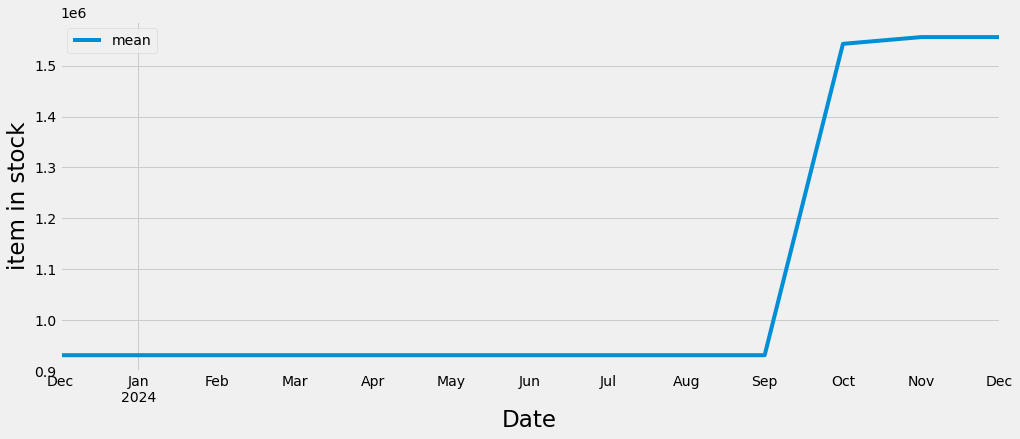

In [80]:
res = result.plot(figsize=(15,6))
res.set_xlabel('Date')
res.set_ylabel('item in stock')
plt.show()